# Regresión espuria

Estos apuntes tienen por objetivo ilustrar el problema que surge de estimar modelos de regresión lineal con series de tiempo no estacionarias (regresión espuria).

En primer lugar, se estima una regresión en la que el PIB per capita de Costa Rica depende del de Malta (a priori, no esperaríamos que el PIB per capita de Malta tenga impacto en el de Costa Rica).  Más adelante, realizamos experimentos de Monte Carlo para analizar las consecuencias de estimar regresiones con datos no estacionarios.

## Preparación

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.api import OLS
from statsmodels.formula.api import ols

pd.set_option('display.float_format',lambda x: '%.2f' % x)
plt.style.use('seaborn')

In [2]:
GITHUB_REPO = "https://raw.githubusercontent.com/randall-romero/econometria/master/data/"
DATAPATH = GITHUB_REPO if 'google.colab' in str(get_ipython()) else '../data/'

Necesitamos importar una clase de un módulo local. Para ello, usualmente es suficiente con tener el módulo (archivo py) en la misma carpeta que este cuaderno, pero eso no funcionaría cuando se corre en Colab. Por ello, añadimos explícitamente la carpeta que contiene ese módulo en el path de Python.

In [3]:
import sys
sys.path.insert(1, DATAPATH)
from mackinnon import MacKinnon  # este módulo contiene herramientas para calcular valores críticos de MacKinnon

La función AEG acá definida realizará la prueba (aún no Aumentada) de Engle y Granger a partir de los residuos de una regresión

In [4]:
mk = MacKinnon()

def AEG(residuals, N, summary=True):
    '''Prueba de cointegración de Engle y Granger'''
    aux = OLS(residuals.diff(), residuals.shift(1), missing='drop').fit()
    t = aux.tvalues[0]
    nobs = aux.nobs
    
    crit = mk('c', N, T=nobs)
    
    if summary:
        print('Prueba de cointegración de Engle y Granger')
        print('ADF stat = %.3f\nCritical values:' % t)
        for k, v in crit.items():
            print('\t%5s: %.3f' % (k,v))
        if t < crit['1%']:
            print('Series están cointegradas (al 1% significancia)')
        elif t < crit['5%']:
            print('Series están cointegradas (al 5% significancia)')
        elif t < crit['10%']:
            print('Series están cointegradas (al 10% significancia)')
        else:
            print('Series no están cointegradas')
    return t
       

## Regresión con datos de Costa Rica y de Malta

Los datos los obtenemos directamente del Banco Mundial, usando el paquete `wbdata`. Las líneas importantes son:

    import wbdata
    df = wbdata.get_dataframe(indicators, country=countries, convert_date=False)

El resto del código da la opción de abrir datos previamente guardados en el directorio.

In [5]:
data_file_name = 'datos-CRI-MLT.pickle'
update_data = False

if update_data:
    try:
        import wbdata
        countries = ["MLT", "CRI"]
        indicators = {'NY.GDP.PCAP.KD':'GDP per capita (constant 2010 US$)'}
        df = wbdata.get_dataframe(indicators, country=countries, convert_date=False)
        data = df.unstack(level=0)['GDP per capita (constant 2010 US$)']
        data.rename(columns={'Costa Rica':'CRI', 'Malta':'MLT'}, inplace=True)
        data.to_pickle(data_file_name)
        print('Downloaded data from World DataBank\nData saved to %s.' % data_file_name)
    except:
        data = pd.read_pickle(DATAPATH + data_file_name)
        print('Could not download data from World DataBank\nData read from %s.' % data_file_name)
else:
    data = pd.read_pickle(DATAPATH + data_file_name)
    print('Reading data from %s.' % data_file_name)

Reading data from datos-CRI-MLT.pickle.


Cargados los datos, los graficamos y mostramos las últimas 8 observaciones en una tabla.

country,CRI,MLT
date,,
2012,8689.97,21691.26
2013,8785.74,22375.04
2014,8993.53,23842.23
2015,9219.39,25798.47
2016,9509.74,26645.86
2017,9732.27,27669.37
2018,9889.74,28594.30
2019,NaN,NaN


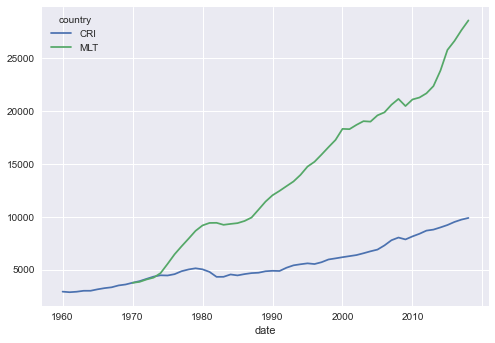

In [6]:
data.plot()
data.tail(8)

Los datos originales están en niveles. Para la regresión
$$ \log(CRI) = c + \log(MLT) + \epsilon $$ 

se necesita calcular el logaritmo de cada serie. Acá simplemente hacemos una base nueva `ldata` a partir de la original.

In [7]:
ldata = np.log(data)

Ahora sí, estimamos la regresión con el función `ols`. Nótese que según los resultados, un aumento de un punto porcentual en el PIB de Malta está asociado con una disminución de 0.4494 pp en Costa Rica; el resultado es estadísticamente significativo. 

In [8]:
model = ols('CRI ~ MLT',ldata)
resultados = model.fit()
resultados.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CRI   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     195.0
Date:                Sun, 24 Apr 2022   Prob (F-statistic):           2.40e-18
Time:                        16:21:30   Log-Likelihood:                 34.197
No. Observations:                  49   AIC:                            -64.39
Df Residuals:                      47   BIC:                            -60.61
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4814      0.300     14.916      0.000       3.877       5.086
MLT            0.4432      0.032     13.966      0.000       0.379       0.507
==============================================================================
Omnibus:                       57.494   Durbin-Watson:                   0.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                5.218
Skew:                           0.156   Prob(JB):                       0.0736
Kurtosis:                       1.432   Cond. No.                         164.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
print(resultados.summary())

                            OLS Regression Results                            
Dep. Variable:                    CRI   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     195.0
Date:                Sun, 24 Apr 2022   Prob (F-statistic):           2.40e-18
Time:                        16:21:30   Log-Likelihood:                 34.197
No. Observations:                  49   AIC:                            -64.39
Df Residuals:                      47   BIC:                            -60.61
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4814      0.300     14.916      0.0

Ahora bien, observe que los residuos no parecen ser ruido blanco.

<AxesSubplot:xlabel='date'>

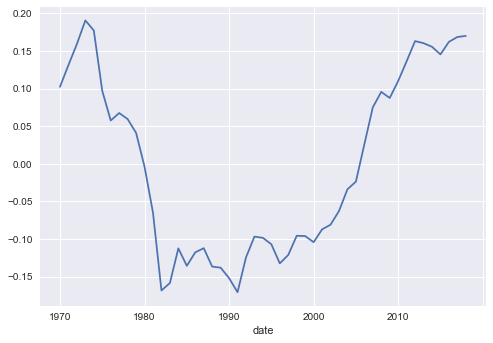

In [10]:
resultados.resid.plot()

Esto lo podemos confirmar con la prueba de Dickey y Fuller. Dado que al parecer los residuos tienen raíz unitaria, podemos inferir que el PIB de Costa Rica **no está cointegrado** con el de Malta.

In [11]:
t=AEG(resultados.resid, 2)

Prueba de cointegración de Engle y Granger
ADF stat = -0.532
Critical values:
	   1%: -4.138
	   5%: -3.470
	  10%: -3.130
Series no están cointegradas


Ahora bien, nótese que el problema de regresión espuria (casi) desaparece una vez corremos la regresión con series estacionarias (en este caso, el crecimiento en cada país).

In [12]:
modeldiff = ols('CRI ~ MLT',ldata.diff())
modeldiff.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CRI   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.537
Date:                Sun, 24 Apr 2022   Prob (F-statistic):              0.221
Time:                        16:21:30   Log-Likelihood:                 102.51
No. Observations:                  48   AIC:                            -201.0
Df Residuals:                      46   BIC:                            -197.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0143      0.006      2.269      0.028       0.002       0.027
MLT            0.1378      0.111      1.240      0.221      -0.086       0.362
==============================================================================
Omnibus:                       27.205   Durbin-Watson:                   1.244
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.241
Skew:                          -1.586   Prob(JB):                     2.26e-13
Kurtosis:                       7.365   Cond. No.                         26.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
print(modeldiff.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                    CRI   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.537
Date:                Sun, 24 Apr 2022   Prob (F-statistic):              0.221
Time:                        16:21:30   Log-Likelihood:                 102.51
No. Observations:                  48   AIC:                            -201.0
Df Residuals:                      46   BIC:                            -197.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0143      0.006      2.269      0.0

## Simulación de datos

Ahora, vamos a definir una función para simular dos caminatas aleatorias con intercepto, calibradas con la media y la desviación estándar del crecimiento en ambos países.

In [14]:
growth = ldata.diff().mean() 
print('El crecimiento medio es:')
print(growth)

sigma = ldata.diff().std()
print('\ny las respectivas volatilidades son:')
print(sigma)

El crecimiento medio es:
country
CRI   0.02
MLT   0.04
dtype: float64

y las respectivas volatilidades son:
country
CRI   0.03
MLT   0.04
dtype: float64


Para las simulaciones, fijamos el tamaño de muestra en `T=48`. Observe que las dos series que se crean son independientes.

In [15]:
T = 48
calendario = pd.date_range(start='1970',freq='A',periods=T)

def generate_series():
    X = np.ones((T,2))
    
    for t in range(1, T):
        X[t] = X[t-1] + growth + sigma * np.random.randn(2)
    
    return pd.DataFrame(X,index=calendario, columns=['MLT','CRI'])

Aquí simulamos el proceso una vez para ver que parezca razonable.

<AxesSubplot:>

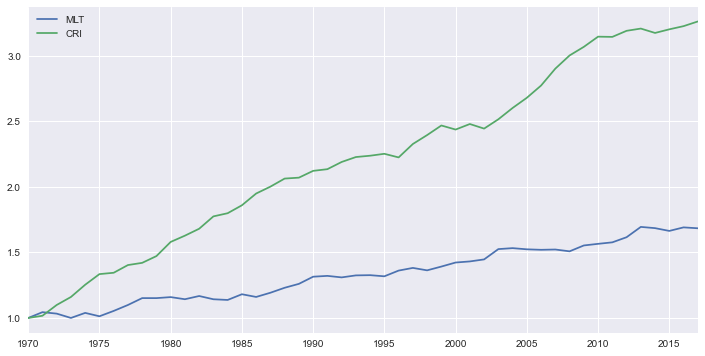

In [16]:
datos_simulados = generate_series()
datos_simulados.plot(figsize=[12,6])

In [17]:
resultados_simulados = ols('CRI ~ MLT',datos_simulados).fit().summary()
resultados_simulados

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CRI   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     1011.
Date:                Sun, 24 Apr 2022   Prob (F-statistic):           5.83e-33
Time:                        16:21:30   Log-Likelihood:                 26.099
No. Observations:                  48   AIC:                            -48.20
Df Residuals:                      46   BIC:                            -44.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9411      0.132    -14.699      0.000      -2.207      -1.675
MLT            3.1141      0.098     31.799      0.000       2.917       3.311
==============================================================================
Omnibus:                        0.901   Durbin-Watson:                   0.508
Prob(Omnibus):                  0.637   Jarque-Bera (JB):                0.840
Skew:                          -0.064   Prob(JB):                        0.657
Kurtosis:                       2.365   Cond. No.                         13.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Monte Carlo

In [18]:
from joblib import Parallel, delayed

def Monte_Carlo(funcion, repeticiones, columnas, *args, **kwargs):
    """
    Ejecuta simulaciones de Montecarlo en paralelo, aprovechando todos los núcleos del procesador

    Argumentos:
        funcion: una función que dé por resultado una única realización de las cantidades que se desean simular
        repeticiones: un entero que indica cuántas muestras se desean simular
        columnas: una lista (o tupla) de strings, que identifiquen a las cantidades individuales retornadas por funcion
        *args, **kwargs: otros parámetros requeridos por funcion

    Retorna:
         Un data frame de pandas, con tantas filas como `repeticiones` y columnas como textos en `columnas`.
    """
    datos = Parallel(n_jobs=-1)(delayed(funcion)(*args, **kwargs) for _ in range(repeticiones))
    return pd.DataFrame(datos, columns=columnas)

Para la simulación de Monte Carlo, veremos el parámetro asociado con MLT, así como su estadístico *t* y el valor *p*. Para facilitar la labor, definimos una función que extrae estos tres estadísticos de los resultados de una regresión y los retorna como una lista. Añadimos ademas el *p-value* de la prueba aumentada de Dickey-Fuller respecto a si los residuos de la regresión presentan raices unitarias.

In [19]:
def give_me_the_summary(res):
    statistics = ['params', 'tvalues', 'pvalues']
    tval = AEG(res.resid, 2,False)
    return [getattr(res, k)['MLT'] for k in statistics] + [tval]

Para cada iteración del experimento de Monte Carlo, generamos una nueva muestra con `generate_series()`, luego estimamos el modelo con los datos en niveles (resultados en `rl`) y en primeras diferencias (`rd`). Retornamos los seis estadísticos correspondientes.

Recuerde que, por construcción, las series en primera diferencia sí son estacionarias.

In [20]:
def simulate_regression():
    data = generate_series()
    rl = ols('CRI ~ MLT', data).fit()
    rd = ols('CRI ~ MLT', data.diff()).fit()
    return give_me_the_summary(rl) + give_me_the_summary(rd)

Fijamos el número de repeticiones en `nrep=1000` y creamos una tabla (`pd.DataFrame`) con los resultados de todas las simulaciones.

In [21]:
%%time

nrep = 10000 # number of repetitions
montecarlo = Monte_Carlo(simulate_regression, nrep, columnas=pd.MultiIndex.from_product([['LEVEL','DIFF'], ['coeff','t-stat', 'p-value', 'tvalue-res']]))

Wall time: 1min 55s


Finalmente, analizamos la distribución de cada uno de los estadísticos bajo consideración.

Level
1%    -4.14
5%    -3.47
10%   -3.13
dtype: float64

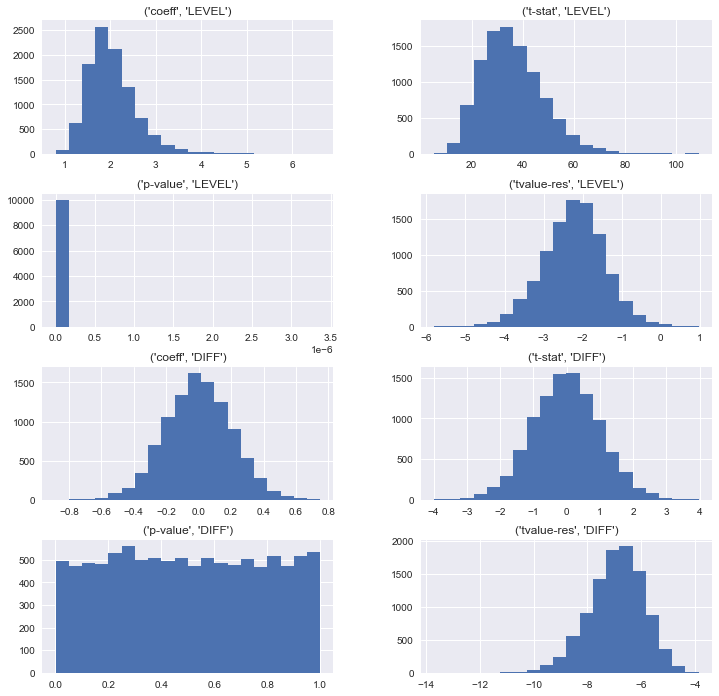

In [22]:
ax = montecarlo.swaplevel(axis=1).hist(layout=(4,2), figsize=[12,12],bins=20)
mk('c', 2, T)

Puede verse para las regresiones en niveles, siempre encontramos una asociación positiva y estadísticamente significativa entre las dos series, a pesar de que son independientes! En contraste, cuando las regresiones se realizan con datos estacionarios (primeras diferencias), rutinariamente rechazaríamos la hipótesis de que el PIB de Malta está correlacionado con el de Costa Rica.